In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import utils
import torch
from sklearn.model_selection import train_test_split
import pickle
# train svm, lr
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import os
from model import Model

In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [22]:
config = utils.read_config()
# set seeds
utils.set_seeds(config['seed'])
behaviour_data, spikes = utils.load_dataset(config)
# consider data from only t = -1
# time_from = int(1/bin_len)
# behaviour_data, spikes = [x[time_from:, :] for x in behaviour_data], [x[time_from:, :] for x in spikes]
num_trials, time_bins, emissions_dim = np.array(spikes).shape
stim_idx, choice_idx = 6, 3
stim = [x[0, stim_idx] for x in behaviour_data]
choice = [x[0, choice_idx] for x in behaviour_data]
num_contacts = [np.sum(x[:, -9:-5], axis=1) for x in behaviour_data]
# concat them
behaviour_data = np.stack((stim, choice), axis=1)
# convert to torch tensors
behaviour_data = np.array(behaviour_data)
# behaviour_data = torch.tensor(behaviour_data, dtype=torch.float32)
spikes = np.array(spikes)
# create dataloader with random sampling for training and testing
# split data into training and testing
# behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.3, random_state=42)
behaviour_data_train, behaviour_data_test, spikes_train, spikes_test = train_test_split(behaviour_data, spikes, test_size=0.2, random_state=7)
trials_train, trials_test = len(behaviour_data_train), len(behaviour_data_test)
# distribution of choice and stimulus in test
print("Train distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_train[:, 0]), np.mean(behaviour_data_train[:, 1])))
print("Test distribution of Stimulus: {}, Choice: {}".format(np.mean(behaviour_data_test[:, 0]), np.mean(behaviour_data_test[:, 1])))
# labels
y_stim_train, y_stim_test = behaviour_data_train[:, 0], behaviour_data_test[:, 0]
y_choice_train, y_choice_test = behaviour_data_train[:, 1], behaviour_data_test[:, 1]

Train distribution of Stimulus: 0.46875, Choice: 0.359375
Test distribution of Stimulus: 0.5454545454545454, Choice: 0.48484848484848486


# Train simple models on spikes for upper bound

Max test accuracy (stimulus): 0.7272727272727273
Max test accuracy (choice): 0.9090909090909091


Text(0.5, 1.0, 'SVM')

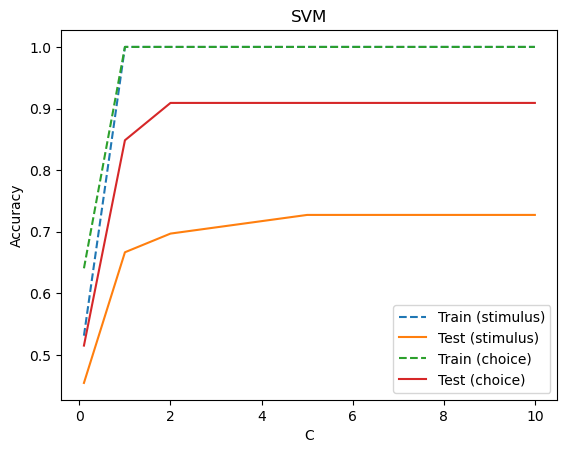

In [23]:
train_acc_stim, test_acc_stim = [], []
train_acc_choice, test_acc_choice = [], []
list_c = [0.1, 1, 2, 5, 10]
for which_beh, y_train, y_test in [('stim', y_stim_train, y_stim_test), ('choice', y_choice_train, y_choice_test)]:
    for c in list_c:
        # train svm
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        clf.fit(spikes_train.reshape(spikes_train.shape[0], -1), y_train)
        # predict
        pred_test = clf.predict(spikes_test.reshape(spikes_test.shape[0], -1))
        pred_train = clf.predict(spikes_train.reshape(spikes_train.shape[0], -1))
        # calculate accuracy
        test_accuracy = accuracy_score(y_test, pred_test)
        train_accuracy = accuracy_score(y_train, pred_train)
        if which_beh == 'stim':
            train_acc_stim.append(train_accuracy)
            test_acc_stim.append(test_accuracy)
        else:
            train_acc_choice.append(train_accuracy)
            test_acc_choice.append(test_accuracy)
# plot
plt.plot(list_c, train_acc_stim, label='Train (stimulus)', linestyle='--')
plt.plot(list_c, test_acc_stim, label='Test (stimulus)')
plt.plot(list_c, train_acc_choice, label='Train (choice)', linestyle='--')
plt.plot(list_c, test_acc_choice, label='Test (choice)')
# print max test accuracy
max_test_acc_stim = np.max(test_acc_stim)
max_test_acc_choice = np.max(test_acc_choice)
print("Max test accuracy (stimulus): {}".format(max_test_acc_stim))
print("Max test accuracy (choice): {}".format(max_test_acc_choice))

plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.title('SVM')


# Load model output

Log det: tensor(-74.5478) Inverse max:  tensor(63.9476) Covariance max:  tensor(0.5100)
Number of trainable parameters in RNN: 3408
Number of trainable parameters in Posterior Mean: 102
Number of trainable parameters in Block Diagonal Z: 51
Number of trainable parameters in Cov X: 153
Number of trainable parameters in VAE: 3975
Using stimulus decoder
Using choice decoder
Scheduler not implemented for decoder
Number of trainable parameters in behavior decoder: 132


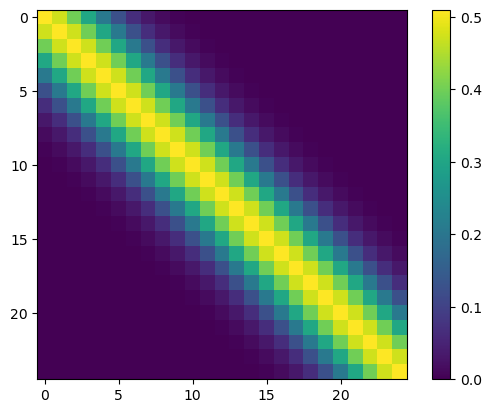

In [25]:
model = Model(config, input_dim=emissions_dim)
filepath = os.path.join(utils.model_store_path(config, model.arch_name), 'res.pkl')
filepath = 'results/dandi_sub-221CR_ses-20190515T160400/100_ms/vae_gp_[1, 1, 1]__bias_gru_8_2_True_noise_0.01_rbfscale_0.5_smoothing_3_monotonic_1_1_20_2_entropy_Nonecnn_8_5/res.pkl'
with open(filepath, 'rb') as f:
    all_data = pickle.load(f)
x_mu_train, z_mu_train, x_mu_test, z_mu_test = all_data[1], all_data[2], all_data[10], all_data[11]
x_mu_train, x_mu_test = x_mu_train.reshape(trials_train, time_bins, -1), x_mu_test.reshape(trials_test, time_bins, -1)

# For each latent z, zero out time bins where z is not the argmax

Data:
* spikes: trials x bins x neurons
* x: trials x bins x x_dim
* z: trials x bins x 3/2

In [27]:
decoding_from = 'spikes' # spikes or mu
# Thresholding based on z to keep only relevant time bins
z_dim = z_mu_train.shape[-1]
argmax_z_train = np.argmax(z_mu_train, axis=2)
argmax_z_test = np.argmax(z_mu_test, axis=2)

y_train, y_test = y_stim_train, y_stim_test
# y_train, y_test = y_choice_train, y_choice_test
list_c = [0.1, 0.5, 1, 2, 5]

for i in range(z_dim):
    # set spikes where z is not i to 0
    if decoding_from == 'spikes':
        x_train, x_test = spikes_train.copy(), spikes_test.copy()
    else:
        x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
    x_train[argmax_z_train != i] = 0
    x_test[argmax_z_test != i] = 0
    # print number of bins kept
    print("Number of time bins kept for z = {}: {}".format(i, np.mean(argmax_z_train == i)))
    for c in list_c:
        # train svm        
        clf = SVC(C=c)
        clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)
        # predict
        pred_test = clf.predict(x_test.reshape(x_test.shape[0], -1))
        pred_train = clf.predict(x_train.reshape(x_train.shape[0], -1))
        # calculate accuracy
        test_accuracy = round(accuracy_score(y_test, pred_test), 3)
        train_accuracy = round(accuracy_score(y_train, pred_train), 3)
        print("C: {}, Train accuracy: {}, Test accuracy: {}".format(c, train_accuracy, test_accuracy))


Number of time bins kept for z = 0: 0.325
C: 0.1, Train accuracy: 0.531, Test accuracy: 0.455
C: 0.5, Train accuracy: 0.75, Test accuracy: 0.424
C: 1, Train accuracy: 0.969, Test accuracy: 0.485
C: 2, Train accuracy: 0.992, Test accuracy: 0.606
C: 5, Train accuracy: 1.0, Test accuracy: 0.606
Number of time bins kept for z = 1: 0.3115625
C: 0.1, Train accuracy: 0.531, Test accuracy: 0.455
C: 0.5, Train accuracy: 0.836, Test accuracy: 0.576
C: 1, Train accuracy: 0.938, Test accuracy: 0.727
C: 2, Train accuracy: 1.0, Test accuracy: 0.758
C: 5, Train accuracy: 1.0, Test accuracy: 0.818
Number of time bins kept for z = 2: 0.3634375
C: 0.1, Train accuracy: 0.531, Test accuracy: 0.455
C: 0.5, Train accuracy: 0.812, Test accuracy: 0.515
C: 1, Train accuracy: 0.938, Test accuracy: 0.545
C: 2, Train accuracy: 0.961, Test accuracy: 0.545
C: 5, Train accuracy: 0.984, Test accuracy: 0.606


# For each latent z, zero out time bins where z < threshold

In [ ]:
# y_train, y_test = y_stim_train, y_stim_test
y_train, y_test = y_choice_train, y_choice_test
threshold = 0.4

for i in range(z_dim):
    # set spikes where z < 0.5 to 0
    # x_train, x_test = spikes_train.copy(), spikes_test.copy()
    x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
    x_train[z_mu_train[:, :, i] < threshold] = 0
    x_test[z_mu_test[:, :, i] < threshold] = 0
    # print number of bins kept
    print("Number of time bins kept for z = {}: {}".format(i, np.mean(z_mu_train[:, :, i] >= threshold)))
    # train svm
    clf = SVC(C=1)
    clf.fit(x_train.reshape(x_train.shape[0], -1), y_train)
    # predict
    pred_test = clf.predict(x_test.reshape(x_test.shape[0], -1))
    # calculate accuracy
    test_accuracy = accuracy_score(y_test, pred_test)
    print("Test accuracy (stimulus) after thresholding z: {}".format(test_accuracy))

# Train and test on time bin surrounding peak z

In [51]:
decoding_from = 'spikes' # spikes or mu
# Thresholding based on z to keep only relevant time bins
z_dim = z_mu_train.shape[-1]

y_train, y_test = y_stim_train, y_stim_test
# y_train, y_test = y_choice_train, y_choice_test
list_c = [0.1, 0.5, 1, 2, 5]
one_sided_window = 2
# concatenate spikes with one sided window on both sides with zeros
spikes_train_ = np.concatenate([np.zeros((trials_train, one_sided_window, emissions_dim)), spikes_train, np.zeros((trials_train, one_sided_window, emissions_dim))], axis=1)
spikes_test_ = np.concatenate([np.zeros((trials_test, one_sided_window, emissions_dim)), spikes_test, np.zeros((trials_test, one_sided_window, emissions_dim))], axis=1)

for i in range(z_dim):
    # set spikes where z is not i to 0
    if decoding_from == 'spikes':
        x_train, x_test = spikes_train_.copy(), spikes_test_.copy()
    else:
        x_train, x_test = x_mu_train.copy(), x_mu_test.copy()
    # find time bin where z peaks
    argmax_z_train = np.argmax(z_mu_train[:, :, i], axis=1)
    # print(argmax_z_train)
    argmax_z_test = np.argmax(z_mu_test[:, :, i], axis=1)    
    # take one sided window
    x_train = np.array([x[argmax_z_train[j]:argmax_z_train[j]+2*one_sided_window+1] for j, x in enumerate(x_train)]).reshape(x_train.shape[0], -1)
    x_test = np.array([x[argmax_z_test[j]:argmax_z_test[j]+2*one_sided_window+1] for j, x in enumerate(x_test)]).reshape(x_test.shape[0], -1)
    # print(x_train.shape, x_test.shape)
    for c in list_c:
        # train svm        
        clf = SVC(C=c)
        # clf = LogisticRegression(penalty='l1', solver='liblinear', C=c)
        clf.fit(x_train, y_train)
        # predict
        pred_test = clf.predict(x_test)
        pred_train = clf.predict(x_train)
        # calculate accuracy
        test_accuracy = round(accuracy_score(y_test, pred_test), 3)
        train_accuracy = round(accuracy_score(y_train, pred_train), 3)
        print("C: {}, Train accuracy: {}, Test accuracy: {}".format(c, train_accuracy, test_accuracy))
    print("")


C: 0.1, Train accuracy: 0.531, Test accuracy: 0.455
C: 0.5, Train accuracy: 0.758, Test accuracy: 0.515
C: 1, Train accuracy: 0.938, Test accuracy: 0.515
C: 2, Train accuracy: 0.984, Test accuracy: 0.576
C: 5, Train accuracy: 1.0, Test accuracy: 0.636

C: 0.1, Train accuracy: 0.531, Test accuracy: 0.455
C: 0.5, Train accuracy: 0.875, Test accuracy: 0.545
C: 1, Train accuracy: 0.953, Test accuracy: 0.697
C: 2, Train accuracy: 0.984, Test accuracy: 0.788
C: 5, Train accuracy: 1.0, Test accuracy: 0.788

C: 0.1, Train accuracy: 0.531, Test accuracy: 0.455
C: 0.5, Train accuracy: 0.758, Test accuracy: 0.455
C: 1, Train accuracy: 0.891, Test accuracy: 0.485
C: 2, Train accuracy: 0.945, Test accuracy: 0.515
C: 5, Train accuracy: 1.0, Test accuracy: 0.515

